In [1]:
import requests 
import pandas as pd
from bs4 import BeautifulSoup
import re
import plotnine as p9
import base64

## 1: Data From unstructured websites 

In [2]:
URL = "https://tastesbetterfromscratch.com/meal-plan-173-2/"

In [3]:
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

response = requests.get(URL, headers = HEADERS)
soup = BeautifulSoup(response.content, "html.parser")

In [4]:
Shopping_list = soup.find_all("div", 
                            attrs={
                            "class": 
                            "wp-block-group__inner-container is-layout-flow wp-block-group-is-layout-flow"})

shop = Shopping_list[0]

In [5]:
meal_plan = []

for val in shop.find_all("p"):
    
    #finding the days of the week that are in this meal plan 
    day_tag = val.find("strong")
    day = day_tag.get_text(strip=True)
    #found that their was some days that ended in : so added regex to detect this and 
    #remvoe the :
    day_C = re.sub(r":$", '', day)
    
    meal_name_tag = val.find("a")
    meal_name = meal_name_tag.get_text(strip=True)

    link_tag = val.find("a")
    link = link_tag.get("href")

    price_tag = val.get_text()
    price = re.search(r"(?<=\$)\d+\.\d{2}", price_tag) 
    price = "$" + price.group(0)

    meal_plan.append({
        "Day of the Week": day_C,
        "Name of Recipe" : meal_name, 
        "Link to Recipe" : link,
        "Price of Recipe": price
    })

meal_plan

[{'Day of the Week': 'Monday',
  'Name of Recipe': 'Tahini Chicken Bowls',
  'Link to Recipe': 'https://tastesbetterfromscratch.com/tahini-chicken-bowls/',
  'Price of Recipe': '$18.69'},
 {'Day of the Week': 'Tuesday',
  'Name of Recipe': 'French Onion Burger',
  'Link to Recipe': 'https://tastesbetterfromscratch.com/french-onion-burgers/',
  'Price of Recipe': '$20.02'},
 {'Day of the Week': 'Wednesday',
  'Name of Recipe': 'Vegetarian Stuffed Peppers',
  'Link to Recipe': 'https://tastesbetterfromscratch.com/southwest-vegetarian-stuffed-peppers/',
  'Price of Recipe': '$19.60'},
 {'Day of the Week': 'Thursday',
  'Name of Recipe': 'Chicken Noodle Soup',
  'Link to Recipe': 'https://tastesbetterfromscratch.com/chicken-noodle-soup/',
  'Price of Recipe': '$10.00'},
 {'Day of the Week': 'Friday',
  'Name of Recipe': 'Meatballs Arrabbiata',
  'Link to Recipe': 'https://tastesbetterfromscratch.com/meatballs-arrabbiata/',
  'Price of Recipe': '$27.81'}]

## 2: Data from an API

In [6]:
recipe = next((r["Name of Recipe"] for r in meal_plan 
                if r.get("Day of the Week", "") == "Monday"), 
                None)
recipe

'Tahini Chicken Bowls'

In [7]:
with open("API.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [8]:
# tasty api code in order to match our monday recipe with their database 

url = "https://tasty.p.rapidapi.com/recipes/list"

querystring = {"from":"0","size":"100","q":recipe}

headers = {
	"x-rapidapi-key": text,
	"x-rapidapi-host": "tasty.p.rapidapi.com"
}

response2 = requests.get(url, headers=headers, params=querystring)

print(response2.json())

{'count': 6, 'results': [{'approved_at': 1529093736, 'aspect_ratio': '1:1', 'beauty_url': 'https://img.buzzfeed.com/video-api-prod/assets/c8aea1b45e3447148abc8a8a96ac081a/beauty1.jpg', 'brand': None, 'brand_id': None, 'buzz_id': None, 'canonical_id': 'recipe:4045', 'compilations': [{'approved_at': 1557284312, 'aspect_ratio': '16:9', 'beauty_url': None, 'buzz_id': None, 'canonical_id': 'compilation:934', 'country': 'US', 'created_at': 1557222713, 'description': None, 'draft_status': 'published', 'facebook_posts': [], 'id': 934, 'is_shoppable': False, 'keywords': None, 'language': 'eng', 'name': '5 Delicious Kebabs You Can Make At Home', 'promotion': 'full', 'show': [{'id': 17, 'name': 'Tasty'}], 'slug': '5-delicious-kebabs-you-can-make-at-home', 'thumbnail_alt_text': '', 'thumbnail_url': 'https://img.buzzfeed.com/thumbnailer-prod-us-east-1/video-api/assets/214923.jpg', 'video_id': 82830, 'video_url': 'https://vid.tasty.co/output/131856/hls24_1557225895.m3u8'}, {'approved_at': 1570070573

In [9]:
api_recipies = pd.json_normalize(response2.json(), "results")
api_recipies["name"]

0                Chicken Gyro Sliders
1      Citrus And Winter Greens Salad
2    Shawarma Nachos As Made By Amina
3        Brussels Sprout Quinoa Salad
4             Mix And Match Meal Prep
5     McCormick® Chickpea Buddha Bowl
Name: name, dtype: object

## 3: automation 

In [10]:
#soup = BeautifulSoup(response.content, "html.parser")

def get_meal_plan_data(num):
    """
    The following function is used to connect a meal plan and find simmilar recipies using the tasty api

    Parameters
    ----------

    num: assosiated with the meal plan number on the tasts better from scratch website 

    Returns
    -------
    Recipe_Data: a pandas data frame that connects the meal on monday with the closest results
    from the tasty api website
    """

    #Step 1:
    #importing the websites html into our python serve to webscape 
    Starting_link = "https://tastesbetterfromscratch.com/meal-plan-" + str(num)
    setup = requests.get(Starting_link, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
    good_soup = BeautifulSoup(setup.content, "html.parser")

    Shopping_list = good_soup.find_all("div", attrs = {"class": "entry-content"})
    web = Shopping_list[0]

    #step 2:
    
    meal_plan = []

    for val in web.find_all("p", attrs = {"class": "has-text-align-left"}):
    
        #finding the days of the week that are in this meal plan 
        day_tag = val.find("strong")
        day = day_tag.get_text(strip=True)
        #found that their was some days that ended in : so added regex to detect this and 
        #remvoe the :
        day_C = re.sub(r":$", '', day)
    
        meal_name_tag = val.find("a")
        meal_name = meal_name_tag.get_text(strip=True)

        link_tag = val.find("a")
        link = link_tag.get("href")

        price_tag = val.get_text()
        price = re.search(r"(?<=\$)\d+\.\d{2}", price_tag) 
        price = "$" + price.group(0)

        meal_plan.append({
            "Day of the Week": day_C,
            "Name of Recipe" : meal_name, 
            "Link to Recipe" : link,
            "Price of Recipe": price
        })    

    #step 3: 
    recipe = next((r["Name of Recipe"] for r in meal_plan 
                if r.get("Day of the Week", "") == "Monday"), 
                None)


    #step 4: 
    url = "https://tasty.p.rapidapi.com/recipes/list"

    querystring = {"from":"0","size":"100","q":recipe}

    headers = {
	"x-rapidapi-key": text,
	"x-rapidapi-host": "tasty.p.rapidapi.com"
    }

    response2 = requests.get(url, headers=headers, params=querystring)

    #step 5

    recipie_data = pd.json_normalize(response2.json(), "results")
    return(recipie_data)

In [11]:
df = get_meal_plan_data(154)
df

,approved_at,aspect_ratio,beauty_url,brand,brand_id,buzz_id,canonical_id,compilations,cook_time_minutes,country,...,show.name,total_time_tier.display_tier,total_time_tier.tier,user_ratings.count_negative,user_ratings.count_positive,user_ratings.score,tips_summary.by_line,tips_summary.content,tips_summary.header,recipes
0,1544125240,1:1,https://img.buzzfeed.com/video-api-prod/assets...,NaN,NaN,NaN,recipe:4635,"[{'approved_at': 1565060055, 'aspect_ratio': '...",20.0,US,...,Tasty,Under 2 hours,under_2_hours,46.0,1140.0,0.961214,NaN,NaN,NaN,NaN
1,1515703373,1:1,https://img.buzzfeed.com/video-api-prod/assets...,NaN,NaN,4722507.0,recipe:3317,"[{'approved_at': 1536951879, 'aspect_ratio': '...",30.0,US,...,Tasty,Under 2 hours,under_2_hours,48.0,732.0,0.938462,Powered By Botatouille,• Bake the calzones instead of frying for a he...,Highlights,NaN
2,1500932370,1:1,None,NaN,NaN,NaN,recipe:1555,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Tasty,Under 45 minutes,under_45_minutes,8.0,129.0,0.941606,NaN,NaN,NaN,NaN
3,1532392106,1:1,https://img.buzzfeed.com/video-api-prod/assets...,NaN,NaN,NaN,recipe:4206,"[{'approved_at': 1565060055, 'aspect_ratio': '...",40.0,US,...,Tasty,Under 1 hour,under_1_hour,7.0,157.0,0.957317,Powered By Botatouille,• Reduce the cooking time to avoid overcooked ...,Highlights,NaN
4,1500932172,1:1,None,NaN,NaN,NaN,recipe:1557,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Tasty,Under 1 hour,under_1_hour,7.0,82.0,0.921348,NaN,NaN,NaN,NaN
5,1500931456,1:1,None,NaN,NaN,NaN,recipe:1554,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Tasty,Under 1 hour,under_1_hour,8.0,55.0,0.873016,NaN,NaN,NaN,NaN
6,1500931870,1:1,None,NaN,NaN,NaN,recipe:1556,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Tasty,Under 45 minutes,under_45_minutes,4.0,22.0,0.846154,NaN,NaN,NaN,NaN
7,1565060055,1:1,None,NaN,NaN,NaN,compilation:1052,NaN,NaN,US,...,Tasty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 4206, '_index': 'recipes-202411251722..."
8,1599833761,1:1,None,NaN,NaN,NaN,compilation:1650,NaN,NaN,US,...,Tasty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 3317, '_index': 'recipes-202411251722..."
9,1580497538,1:1,None,NaN,NaN,NaN,compilation:1384,NaN,NaN,US,...,Tasty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 4635, '_index': 'recipes-202411251722..."


## 4: Fuzzy matching 

In [12]:
MEAT_KEYWORDS = {
    # red meats & game
    "beef","steak","ground beef","minced beef","hamburger","veal",
    "pork","pork chop","pork belly","ribs","spare ribs","pulled pork","bacon","ham",
    "lamb","mutton","goat","chevon","venison","bison","buffalo","boar","rabbit","hare",

    # poultry
    "chicken","chicken breast","chicken thigh","drumstick","wings",
    "turkey","ground turkey","duck","goose","quail","pheasant",

    # processed/cured
    "sausage","bratwurst","kielbasa","chorizo","pepperoni","salami",
    "mortadella","soppressata","bologna","pastrami","corned beef","hot dog","prosciutto","pancetta","spam",

    # fish (common)
    "salmon","tuna","cod","haddock","halibut","tilapia","trout","catfish",
    "mackerel","sardine","anchovy","snapper","sole","pollock",

    # shellfish & cephalopods
    "shrimp","prawn","crab","lobster","scallop","clam","mussel","oyster",
    "squid","calamari","octopus",

    # generic terms
    "meat","meatball","meatballs","meatloaf"
}

In [13]:
ALT = "|".join(map(re.escape, sorted(MEAT_KEYWORDS, key=len, reverse=True)))
MEAT_RE = re.compile(rf"\b(?:{ALT})\b", flags=re.IGNORECASE)

df["vegitarian"] = ~df["name"].str.contains(MEAT_RE, na=False)
df

,approved_at,aspect_ratio,beauty_url,brand,brand_id,buzz_id,canonical_id,compilations,cook_time_minutes,country,...,total_time_tier.display_tier,total_time_tier.tier,user_ratings.count_negative,user_ratings.count_positive,user_ratings.score,tips_summary.by_line,tips_summary.content,tips_summary.header,recipes,vegitarian
0,1544125240,1:1,https://img.buzzfeed.com/video-api-prod/assets...,NaN,NaN,NaN,recipe:4635,"[{'approved_at': 1565060055, 'aspect_ratio': '...",20.0,US,...,Under 2 hours,under_2_hours,46.0,1140.0,0.961214,NaN,NaN,NaN,NaN,False
1,1515703373,1:1,https://img.buzzfeed.com/video-api-prod/assets...,NaN,NaN,4722507.0,recipe:3317,"[{'approved_at': 1536951879, 'aspect_ratio': '...",30.0,US,...,Under 2 hours,under_2_hours,48.0,732.0,0.938462,Powered By Botatouille,• Bake the calzones instead of frying for a he...,Highlights,NaN,True
2,1500932370,1:1,None,NaN,NaN,NaN,recipe:1555,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Under 45 minutes,under_45_minutes,8.0,129.0,0.941606,NaN,NaN,NaN,NaN,False
3,1532392106,1:1,https://img.buzzfeed.com/video-api-prod/assets...,NaN,NaN,NaN,recipe:4206,"[{'approved_at': 1565060055, 'aspect_ratio': '...",40.0,US,...,Under 1 hour,under_1_hour,7.0,157.0,0.957317,Powered By Botatouille,• Reduce the cooking time to avoid overcooked ...,Highlights,NaN,True
4,1500932172,1:1,None,NaN,NaN,NaN,recipe:1557,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Under 1 hour,under_1_hour,7.0,82.0,0.921348,NaN,NaN,NaN,NaN,True
5,1500931456,1:1,None,NaN,NaN,NaN,recipe:1554,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Under 1 hour,under_1_hour,8.0,55.0,0.873016,NaN,NaN,NaN,NaN,False
6,1500931870,1:1,None,NaN,NaN,NaN,recipe:1556,"[{'approved_at': 1500932377, 'aspect_ratio': '...",20.0,US,...,Under 45 minutes,under_45_minutes,4.0,22.0,0.846154,NaN,NaN,NaN,NaN,True
7,1565060055,1:1,None,NaN,NaN,NaN,compilation:1052,NaN,NaN,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 4206, '_index': 'recipes-202411251722...",True
8,1599833761,1:1,None,NaN,NaN,NaN,compilation:1650,NaN,NaN,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 3317, '_index': 'recipes-202411251722...",True
9,1580497538,1:1,None,NaN,NaN,NaN,compilation:1384,NaN,NaN,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 4635, '_index': 'recipes-202411251722...",True


## 5: Analzing Tasty API data

C:\Users\ldcal\anaconda3\Lib\site-packages\plotnine\layer.py:356: PlotnineWarning: position_stack : Removed 8 rows containing missing values.


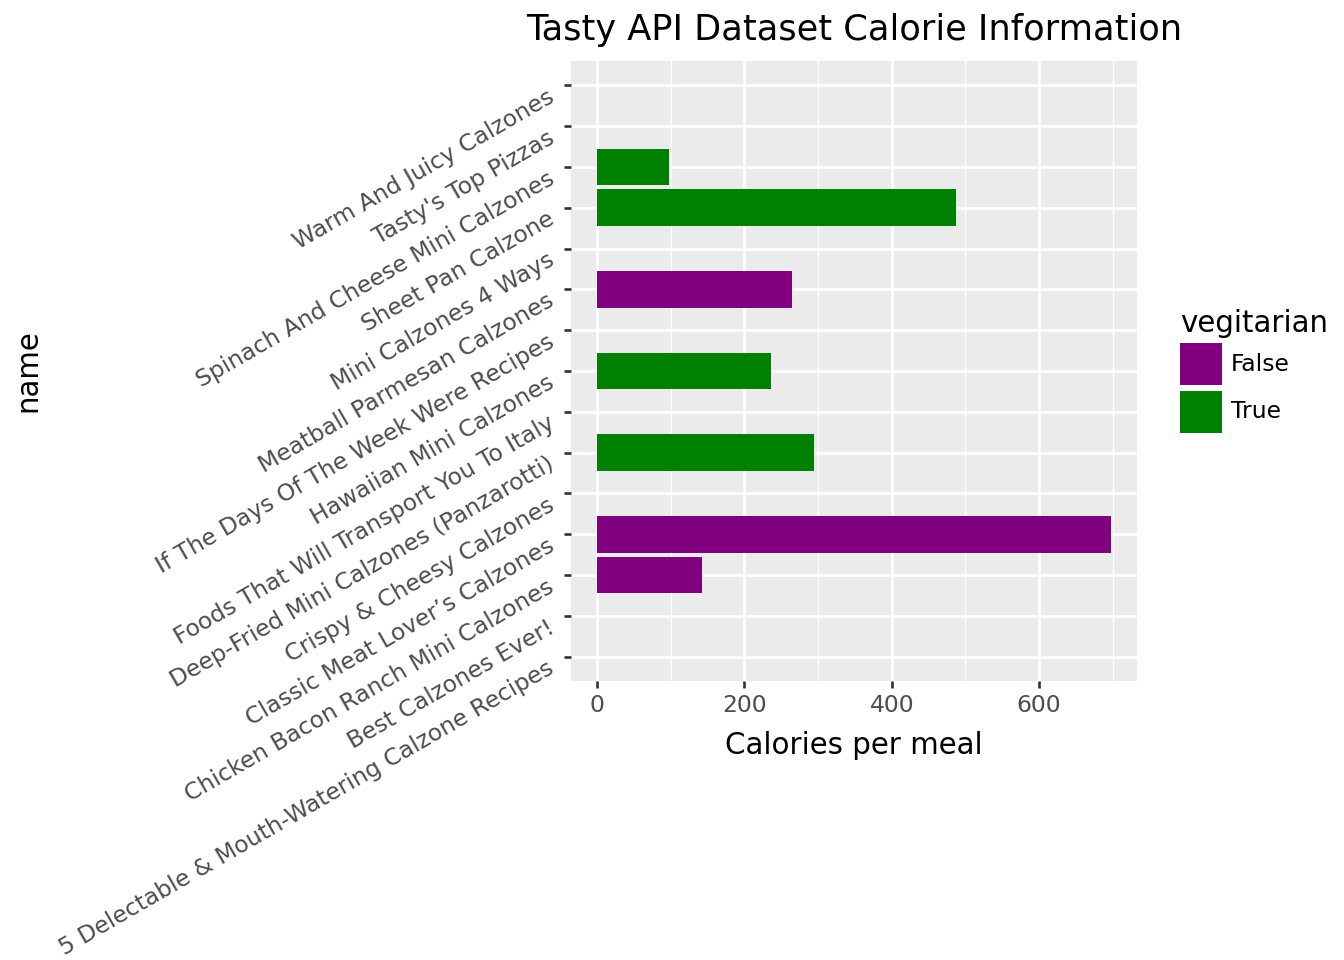

In [14]:
(p9.ggplot(df, p9.aes(x = "name", y = "nutrition.calories", fill = "vegitarian"))
+p9.labs(title = "Tasty API Dataset Calorie Information", y = "Calories per meal")
+p9.scale_fill_manual(values = ("purple", "green"))
+p9.coord_flip()
+p9.theme(axis_text_y=p9.element_text(angle = 30, hjust = 1, vjust = 1))
+p9.geom_col())